# Import Dependencies

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style('white')

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm_notebook

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input, Dropout, BatchNormalization, Activation, Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
import tensorflow as tf
from keras.preprocessing.image import array_to_img, img_to_array, load_img

import time
t_start = time.time()

Using TensorFlow backend.


In [2]:
print(tf.__version__)

1.10.1


# Pre-process Data

In [3]:
DATA_DIR = 'data/salt/'

In [4]:
cv_total = 5
cv_index = 3  # 0,1,2,3,4

In [5]:
version = 5
basic_name = f'unet_v2_{version}'
save_model_name = basic_name + 'A_cv' + str(cv_index) + '.model'
save_model_nameB = basic_name + 'B_cv' + str(cv_index) + '.model'
submission_file = basic_name + '_cv' + str(cv_index) + '.csv'

print(save_model_name)
print(save_model_nameB)
print(submission_file)

unet_v2_5A_cv3.model
unet_v2_5B_cv3.model
unet_v2_5_cv3.csv


In [6]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):# not used
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [7]:
# Loading of training/testing ids and depths
train_df = pd.read_csv(f"{DATA_DIR}train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv(f"{DATA_DIR}depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

len(train_df)

4000

In [8]:
train_df["images"] = [np.array(load_img(f"{DATA_DIR}train/images/{idx}.png", color_mode='grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

In [9]:
train_df["masks"] = [np.array(load_img(f"{DATA_DIR}train/masks/{idx}.png", color_mode='grayscale')) / 255 for idx in tqdm_notebook(train_df.index)]

In [10]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

Text(0.5, 0, 'Coverage class')

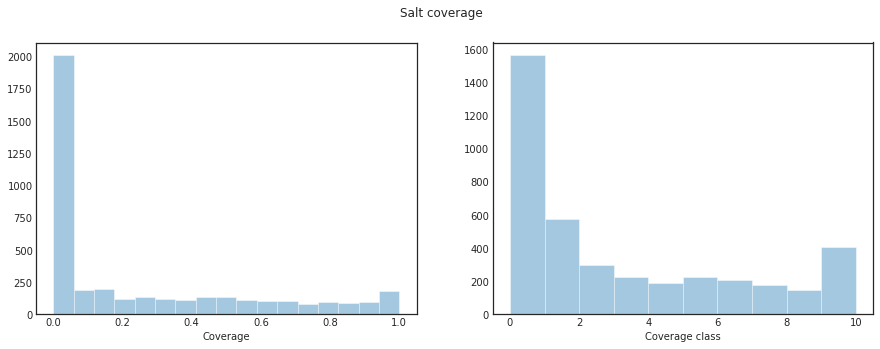

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0.5, 1.0, 'Depth distribution')

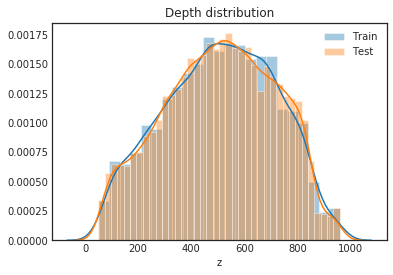

In [12]:
# Plotting the depth distributions

sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

# Split Data

In [13]:
# # Create train/validation split stratified by salt coverage
# ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = \
# train_test_split(train_df.index.values, 
#                  np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
#                  np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1),
#                  train_df.coverage.values, 
#                  train_df.z.values, 
#                  test_size=0.2, stratify=train_df.coverage_class, random_state=555)

In [14]:
train_all = []
evaluate_all = []
skf = StratifiedKFold(n_splits=cv_total, random_state=555, shuffle=True)

for train_index, evaluate_index in skf.split(train_df.index.values, train_df.coverage_class):
    train_all.append(train_index)
    evaluate_all.append(evaluate_index)
    print(train_index.shape, evaluate_index.shape) # the shape is slightly different in different cv, it's OK

(3196,) (804,)
(3199,) (801,)
(3200,) (800,)
(3201,) (799,)
(3204,) (796,)


In [15]:
def get_cv_data(cv_index):
    train_index = train_all[cv_index-1]
    evaluate_index = evaluate_all[cv_index-1]
    x_train = np.array(train_df.images[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_train = np.array(train_df.masks[train_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    x_valid = np.array(train_df.images[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    y_valid = np.array(train_df.masks[evaluate_index].map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1)
    return x_train,y_train,x_valid,y_valid

In [16]:
x_train, y_train, x_valid, y_valid =  get_cv_data(cv_index+1)    

In [17]:
x_train[5,5,5]

array([0.70588235])

In [18]:
len(x_train), len(y_train)

(3201, 3201)

In [19]:
len(x_train), len(y_train)

(3201, 3201)

In [20]:
# boolean mask for mask with either all black pixel or at least 20 pixels
thres = 10
y_mask = np.squeeze((y_train.sum(axis=1).sum(axis=1)>=thres) | (y_train.sum(axis=1).sum(axis=1)==0))

In [21]:
# sample to remove
len(y_train)-y_mask.sum()

31

In [22]:
x_train = x_train[y_mask]
y_train = y_train[y_mask]

In [23]:
len(x_train), len(y_train)

(3170, 3170)

In [24]:
x_train_orig_len = len(x_train)
x_train_orig_len

3170

In [25]:
# only remove train, do not remove validation
len(x_valid), len(y_valid)

(799, 799)

# Data augmentation

In [26]:
def plot2x2Array(image, mask):
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image, cmap="gray")
    axarr[1].imshow(mask, cmap="gray")
    axarr[0].grid(False)
    axarr[1].grid(False)
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

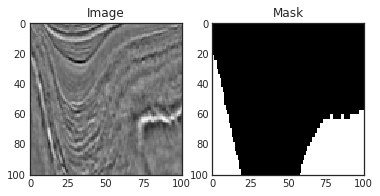

In [27]:
i = 21
plot2x2Array(x_train[i,:,:,0], y_train[i,:,:,0])

In [28]:
from imgaug import augmenters as iaa
import imgaug as ia

sometimes = lambda aug: iaa.Sometimes(0.9, aug)

In [29]:
affine_seq = iaa.Sequential(
    [
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.05),
            pad_mode= 'symmetric',
            pad_cval=(0, 1),
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.95, 1.05), "y": (0.95, 1.05)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}, # translate by -20 to +20 percent (per axis)
            shear=(-5, 5), # shear by -16 to +16 degrees
            cval=(0, 1), # if mode is constant, use a cval between 0 and 255
            mode='symmetric',
        )),
    
], random_order=True)

In [30]:
seq_det = affine_seq.to_deterministic()
aug_img = seq_det.augment_image(x_train[i,:,:])
aug_mask = seq_det.augment_image(y_train[i,:,:])

In [31]:
# plot2x2Array(x_train[i,:,:,0], aug_img[:,:,0])
# plot2x2Array(y_train[i,:,:,0], aug_mask[:,:,0])

In [32]:
aug_mask = np.where(aug_mask[:,:,0] > 0.5, 1, 0)

In [33]:
np.unique(y_train[i,:,:,0])

array([0., 1.])

In [34]:
np.unique(aug_mask)

array([0, 1])

In [35]:
# plot2x2Array(y_train[i,:,:,0], aug_mask)

In [36]:
# x = x_train[21]
# y = y_train[21]
# print((x.shape),(y.shape))

# seq_det = affine_seq.to_deterministic()
# aug_img = seq_det.augment_image(x)
# aug_mask = seq_det.augment_image(y)
# aug_mask[:,:,0] = np.where(aug_mask[:,:,0] > 0.5, 1, 0)

# print((aug_img.shape),(aug_mask.shape))
# plot2x2Array(x[:,:,0], y[:,:,0])

# plot2x2Array(aug_img[:,:,0], aug_mask[:,:,0])

In [37]:
# x_aug_list=[]
# y_aug_list=[]

# for x,y in tqdm_notebook(zip(x_train, y_train)):
#     seq_det = affine_seq.to_deterministic()
    
#     aug_img = seq_det.augment_image(x)
#     aug_mask = seq_det.augment_image(y)
#     aug_mask[:,:,0] = np.where(aug_mask[:,:,0] > 0.5, 1, 0)

#     x_aug_list.append(aug_img)
#     y_aug_list.append(aug_mask)

In [38]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

In [39]:
# x_aug = np.array(x_aug_list)
# y_aug = np.array(y_aug_list)

In [40]:
# x_aug.shape

In [41]:
# x_train = np.append(x_train, x_aug, axis=0)
# y_train = np.append(y_train, y_aug, axis=0)

In [42]:
print(x_train.shape)
print(y_valid.shape)

(6340, 101, 101, 1)
(799, 101, 101, 1)


In [43]:
# i = 188
# plot2x2Array(x_train[i,:,:,0], y_train[i,:,:,0])

In [44]:
# plot2x2Array(x_train[i+x_train_orig_len,:,:,0], y_train[i+x_train_orig_len,:,:,0])

# Model Definitions

In [45]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

In [46]:
# Build Model
def build_model(input_layer, start_neurons, DropoutRatio=0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(input_layer)
    conv1 = residual_block(conv1, start_neurons*1)
    conv1 = residual_block(conv1, start_neurons*1, True)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)
    
    # 50 -> 25
    conv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(pool1)
    conv2 = residual_block(conv2, start_neurons*2)
    conv2 = residual_block(conv2, start_neurons*2, True)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    
    # 25 -> 12
    conv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(pool2)
    conv3 = residual_block(conv3, start_neurons*4)
    conv3 = residual_block(conv3, start_neurons*4, True)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)
    
    # 12 -> 6
    conv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(pool3)
    conv4 = residual_block(conv4, start_neurons*8)
    conv4 = residual_block(conv4, start_neurons*8, True)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    
    # Middle
    convm = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(pool4)
    convm = residual_block(convm, start_neurons*16)
    convm = residual_block(convm, start_neurons*16, True)
    
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons*8)
    uconv4 = residual_block(uconv4, start_neurons*8, True)
    
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons*4, (3,3), strides=(2,2), padding='valid')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons*4)
    uconv3 = residual_block(uconv3, start_neurons*4, True)
    
    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons*2, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons*2)
    uconv2 = residual_block(uconv2, start_neurons*2, True)
    
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons*1, (3,3), strides=(2,2), padding='valid')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons*1)
    uconv1 = residual_block(uconv1, start_neurons*1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding='same', activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

# Metric Loss

In [47]:
def get_iou_vector(A, B):
    batch_size = A.shape[0]
    metric = []
    for batch in range(batch_size):
        t, p = A[batch]>0, B[batch]>0
        intersection = np.logical_and(t, p)
        union = np.logical_or(t, p)
        iou = (np.sum(intersection > 0) + 1e-10 )/ (np.sum(union > 0) + 1e-10)
        thresholds = np.arange(0.5, 1, 0.05)
        s = []
        for thresh in thresholds:
            s.append(iou > thresh)
        metric.append(np.mean(s))
        
    return np.mean(metric)

def my_iou_metric(label, pred):
    return tf.py_func(get_iou_vector, [label, pred>0.5], tf.float64)

def my_iou_metric_2(label, pred):
    return tf.py_func(get_iou_vector, [label, pred >0], tf.float64)

In [48]:
# code download from: https://github.com/bermanmaxim/LovaszSoftmax
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    gts = tf.reduce_sum(gt_sorted)
    intersection = gts - tf.cumsum(gt_sorted)
    union = gts + tf.cumsum(1. - gt_sorted)
    jaccard = 1. - intersection / union
    jaccard = tf.concat((jaccard[0:1], jaccard[1:] - jaccard[:-1]), 0)
    return jaccard

# --------------------------- BINARY LOSSES ---------------------------

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        def treat_image(log_lab):
            log, lab = log_lab
            log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
            log, lab = flatten_binary_scores(log, lab, ignore)
            return lovasz_hinge_flat(log, lab)
        losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
        loss = tf.reduce_mean(losses)
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """

    def compute_loss():
        labelsf = tf.cast(labels, logits.dtype)
        signs = 2. * labelsf - 1.
        errors = 1. - logits * tf.stop_gradient(signs)
        errors_sorted, perm = tf.nn.top_k(errors, k=tf.shape(errors)[0], name="descending_sort")
        gt_sorted = tf.gather(labelsf, perm)
        grad = lovasz_grad(gt_sorted)
        loss = tf.tensordot(tf.nn.elu(errors_sorted), tf.stop_gradient(grad), 1, name="loss_non_void")
        return loss

    # deal with the void prediction case (only void pixels)
    loss = tf.cond(tf.equal(tf.shape(logits)[0], 0),
                   lambda: tf.reduce_sum(logits) * 0.,
                   compute_loss,
                   strict=True,
                   name="loss"
                   )
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = tf.reshape(scores, (-1,))
    labels = tf.reshape(labels, (-1,))
    if ignore is None:
        return scores, labels
    valid = tf.not_equal(labels, ignore)
    vscores = tf.boolean_mask(scores, valid, name='valid_scores')
    vlabels = tf.boolean_mask(labels, valid, name='valid_labels')
    return vscores, vlabels

def lovasz_loss(y_true, y_pred):
    y_true, y_pred = K.cast(K.squeeze(y_true, -1), 'int32'), K.cast(K.squeeze(y_pred, -1), 'float32')
    #logits = K.log(y_pred / (1. - y_pred))
    logits = y_pred #Jiaxin
    loss = lovasz_hinge(logits, y_true, per_image = True, ignore = None)
    return loss

# Build Model

In [49]:
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16, 0.5)

model1 = Model(input_layer, output_layer)

In [50]:
epochs = 300
batch_size = 64
c = optimizers.Adam(lr=0.001)

model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

# model1.summary()

In [51]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric', mode='max', patience=21, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name, monitor='val_my_iou_metric', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode='max', factor=0.5, patience=7, min_lr=0.00001, verbose=1)

In [52]:
%%time
history = model1.fit(x_train, y_train,
                     validation_data = [x_valid, y_valid], 
                     epochs = epochs, 
                     batch_size = batch_size, 
                     callbacks = [early_stopping, model_checkpoint, reduce_lr],
                     verbose = 2)

Train on 6340 samples, validate on 799 samples
Epoch 1/300
 - 89s - loss: 0.4620 - my_iou_metric: 0.2275 - val_loss: 1.1629 - val_my_iou_metric: 0.1772

Epoch 00001: val_my_iou_metric improved from -inf to 0.17722, saving model to unet_v2_5A_cv3.model
Epoch 2/300
 - 73s - loss: 0.3106 - my_iou_metric: 0.4803 - val_loss: 0.6335 - val_my_iou_metric: 0.3036

Epoch 00002: val_my_iou_metric improved from 0.17722 to 0.30363, saving model to unet_v2_5A_cv3.model
Epoch 3/300
 - 73s - loss: 0.2633 - my_iou_metric: 0.5416 - val_loss: 0.2907 - val_my_iou_metric: 0.5872

Epoch 00003: val_my_iou_metric improved from 0.30363 to 0.58723, saving model to unet_v2_5A_cv3.model
Epoch 4/300
 - 73s - loss: 0.2426 - my_iou_metric: 0.5560 - val_loss: 0.9113 - val_my_iou_metric: 0.3225

Epoch 00004: val_my_iou_metric did not improve from 0.58723
Epoch 5/300
 - 73s - loss: 0.2248 - my_iou_metric: 0.5860 - val_loss: 0.2441 - val_my_iou_metric: 0.6136

Epoch 00005: val_my_iou_metric improved from 0.58723 to 0.61


Epoch 00046: val_my_iou_metric did not improve from 0.76996
Epoch 47/300
 - 72s - loss: 0.1066 - my_iou_metric: 0.7621 - val_loss: 0.1212 - val_my_iou_metric: 0.7702

Epoch 00047: val_my_iou_metric improved from 0.76996 to 0.77021, saving model to unet_v2_5A_cv3.model
Epoch 48/300
 - 73s - loss: 0.0996 - my_iou_metric: 0.7747 - val_loss: 0.1588 - val_my_iou_metric: 0.7688

Epoch 00048: val_my_iou_metric did not improve from 0.77021
Epoch 49/300
 - 73s - loss: 0.1014 - my_iou_metric: 0.7752 - val_loss: 0.1306 - val_my_iou_metric: 0.7677

Epoch 00049: val_my_iou_metric did not improve from 0.77021
Epoch 50/300
 - 73s - loss: 0.0982 - my_iou_metric: 0.7759 - val_loss: 0.1477 - val_my_iou_metric: 0.7594

Epoch 00050: val_my_iou_metric did not improve from 0.77021
Epoch 51/300
 - 73s - loss: 0.0953 - my_iou_metric: 0.7795 - val_loss: 0.1399 - val_my_iou_metric: 0.7636

Epoch 00051: val_my_iou_metric did not improve from 0.77021
Epoch 52/300
 - 73s - loss: 0.0964 - my_iou_metric: 0.7761 - v

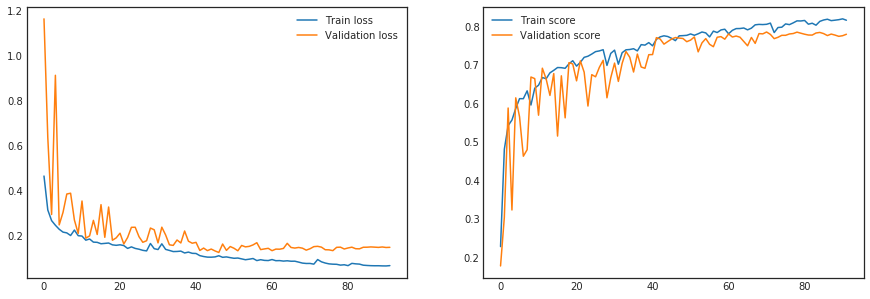

In [53]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric"], label="Validation score")
ax_score.legend()

# Remove activation layer and use lovasz loss

In [50]:
model1 = load_model(save_model_name, custom_objects={'my_iou_metric':my_iou_metric})

input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
c = optimizers.adam(lr=0.0005)

model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

# model.summary()

In [51]:
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=15, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameB, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max',factor=0.5, patience=6, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

In [52]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[ model_checkpoint, reduce_lr, early_stopping], 
                    verbose=2)

Train on 6340 samples, validate on 799 samples
Epoch 1/200
 - 208s - loss: -1.0996e-01 - my_iou_metric_2: 0.8004 - val_loss: 0.0583 - val_my_iou_metric_2: 0.7682

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.76821, saving model to unet_v2_5B_cv3.model
Epoch 2/200
 - 193s - loss: -1.2772e-01 - my_iou_metric_2: 0.7970 - val_loss: 0.0183 - val_my_iou_metric_2: 0.7835

Epoch 00002: val_my_iou_metric_2 improved from 0.76821 to 0.78348, saving model to unet_v2_5B_cv3.model
Epoch 3/200
 - 193s - loss: -1.5185e-01 - my_iou_metric_2: 0.8018 - val_loss: -6.9490e-02 - val_my_iou_metric_2: 0.7927

Epoch 00003: val_my_iou_metric_2 improved from 0.78348 to 0.79274, saving model to unet_v2_5B_cv3.model
Epoch 4/200
 - 193s - loss: -1.9173e-01 - my_iou_metric_2: 0.8100 - val_loss: -2.3549e-02 - val_my_iou_metric_2: 0.7831

Epoch 00004: val_my_iou_metric_2 did not improve from 0.79274
Epoch 5/200
 - 193s - loss: -1.8148e-01 - my_iou_metric_2: 0.8071 - val_loss: -5.7991e-02 - val_my_iou_metri


Epoch 00042: val_my_iou_metric_2 did not improve from 0.81927
Epoch 00042: early stopping
CPU times: user 1h 11min 1s, sys: 20min 10s, total: 1h 31min 12s
Wall time: 2h 16min 14s


# Plot result

# Final Tuning

In [49]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

c = optimizers.Adam(lr = 0.0001)
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

epochs = 200
batch_size = 16

early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode='max', patience=12, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_nameB, monitor='val_my_iou_metric_2', mode='max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode='max',factor=0.5, patience=5, min_lr=0.00001, verbose=2)

In [50]:
%%time
history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint, reduce_lr, early_stopping], 
                    verbose=2)

Train on 6340 samples, validate on 799 samples
Epoch 1/200
 - 242s - loss: -3.5111e-01 - my_iou_metric_2: 0.8379 - val_loss: -1.7566e-01 - val_my_iou_metric_2: 0.8158

Epoch 00001: val_my_iou_metric_2 improved from -inf to 0.81577, saving model to unet_v2_5B_cv3.model
Epoch 2/200
 - 228s - loss: -3.7104e-01 - my_iou_metric_2: 0.8443 - val_loss: -1.5100e-01 - val_my_iou_metric_2: 0.8074

Epoch 00002: val_my_iou_metric_2 did not improve from 0.81577
Epoch 3/200
 - 227s - loss: -3.4513e-01 - my_iou_metric_2: 0.8411 - val_loss: -1.8537e-01 - val_my_iou_metric_2: 0.8186

Epoch 00003: val_my_iou_metric_2 improved from 0.81577 to 0.81865, saving model to unet_v2_5B_cv3.model
Epoch 4/200
 - 228s - loss: -3.7237e-01 - my_iou_metric_2: 0.8420 - val_loss: -1.5286e-01 - val_my_iou_metric_2: 0.8131

Epoch 00004: val_my_iou_metric_2 did not improve from 0.81865
Epoch 5/200
 - 228s - loss: -3.7101e-01 - my_iou_metric_2: 0.8431 - val_loss: -1.6125e-01 - val_my_iou_metric_2: 0.8179

Epoch 00005: val_my

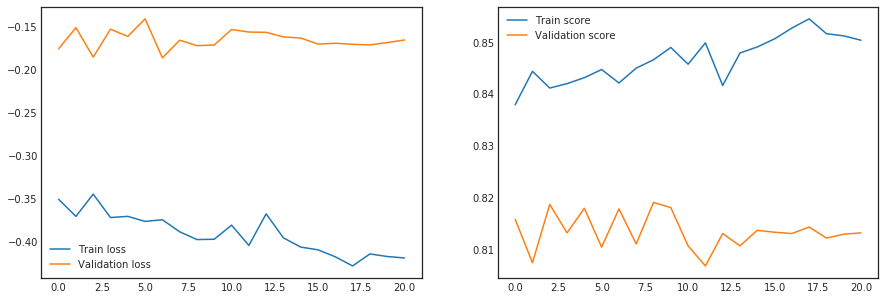

In [51]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

In [52]:
model = load_model(save_model_nameB,custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                   'lovasz_loss': lovasz_loss})

In [53]:
def predict_result(model,x_test,img_size_target): # predict both orginal and reflect x
    x_test_reflect =  np.array([np.fliplr(x) for x in x_test])
    preds_test = model.predict(x_test).reshape(-1, img_size_target, img_size_target)
    preds_test2_refect = model.predict(x_test_reflect).reshape(-1, img_size_target, img_size_target)
    preds_test += np.array([ np.fliplr(x) for x in preds_test2_refect] )
    return preds_test/2

In [54]:
preds_valid = predict_result(model,x_valid,img_size_target)

In [55]:
#Score the model and do a threshold optimization by the best IoU.

# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in


    true_objects = 2
    pred_objects = 2

    #  if all zeros, original code  generate wrong  bins [-0.5 0 0.5],
    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))
#     temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))
    #print(temp1)
    intersection = temp1[0]
    #print("temp2 = ",temp1[1])
    #print(intersection.shape)
   # print(intersection)
    # Compute areas (needed for finding the union between all objects)
    #print(np.histogram(labels, bins = true_objects))
    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    #print("area_true = ",area_true)
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
  
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union
    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
        
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [56]:
## Scoring for last model, choose threshold by validation data 
thresholds_ori = np.linspace(0.3, 0.7, 31)
# Reverse sigmoid function: Use code below because the  sigmoid activation was removed
thresholds = np.log(thresholds_ori/(1-thresholds_ori)) 

# ious = np.array([get_iou_vector(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
# print(ious)
ious = np.array([iou_metric_batch(y_valid, preds_valid > threshold) for threshold in tqdm_notebook(thresholds)])
print(ious)


[0.81276596 0.81376721 0.8146433  0.81652065 0.81714643 0.81727159
 0.81739675 0.81777222 0.81914894 0.81989987 0.82152691 0.822403
 0.82252816 0.82277847 0.82290363 0.82465582 0.82478098 0.82478098
 0.82415519 0.82377972 0.82365457 0.82265332 0.82302879 0.82365457
 0.82490613 0.82428035 0.82440551 0.82403004 0.82302879 0.82202753
 0.82190238]


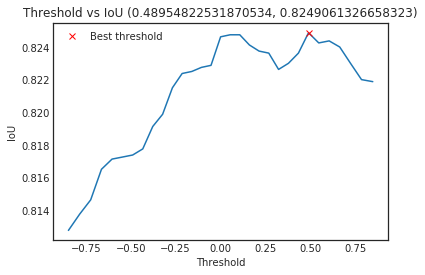

In [57]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, 'xr', label='Best threshold')
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [58]:
def rle_encode(im):
    '''
    im: numpy array, 1-mask, 0-background
    Returns run length as string
    '''
    pixels = im.flatten(order='F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [59]:
x_test = np.array([(np.array(load_img(f"{DATA_DIR}test/images/{idx}.png", color_mode='grayscale'))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [60]:
preds_test = predict_result(model,x_test,img_size_target)

In [61]:
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [62]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(submission_file)

In [63]:
t_finish = time.time()
print(f"Kernel run time = {(t_finish-t_start)/3600} hours")

Kernel run time = 1.4191663457287682 hours
